# Project Overview


Fake task attack is critical for Mobile Crowdsensing system (MCS) that aim to clog the sensing servers in the MCS platform and drain more energy from participants’ smart devices. Typically, fake tasks are created by empirical model such as CrowdSenSim tool. Recently, cyber criminals deploy more intelligent mechanisms to create attacks. Generative Adversarial Network (GAN) is one of the most powerful techniques to generate synthetic samples. GAN considers the entire data in the training dataset to create similar samples. This project aims to use GAN to create fake tasks and verify fake task detection performance.

# The Project Methodology

![image](https://drive.google.com/uc?export=view&id=1DqTuRozMCieSHShD5_udzpP2MxR8MTFo)

Figure 1 Cascade detection framework overview [1]


Project Steps:

1. Prepare the dataset For training
2. Implement classic classifiers (Adaboost and RF) and train them
3. Verify detection performance using test dataset and compare the results
4. Implement Conditional GAN with Wasserstein loss [2].
5. Train the CGAN on the training dataset
6. Generate synthetic fake tasks via Generator network in CGAN after the training procedure
7. Mix the generated fake tasks with the original test dataset to obtain a new test dataset
8. Obtain Adaboost and RF detection performance using the new test dataset and compare the results
9. Consider the Discriminator to as the first level classifier and RF/Adaboost as the second level classifier


**Reference**
- [1] Chen, Zhiyan, and Burak Kantarci. "Generative Adversarial Network-Driven Detection of AdversarialTasks in Mobile Crowdsensing."arXiv preprint arXiv:2202.07802 (2022).
- [2] Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014).

# Prepare the dataset For training

## Import important libraries

In [1]:
!pip install imbalanced-learn
!pip install gdown

  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for gdown: filename=gdown-4.5.1-py3-none-any.whl size=14933 sha256=36b20626e3a608c974cfcce9360d02d93c861751cc4a5759a1bcd791776cd6f8
  Stored in directory: /root/.cache/pip/wheels/3d/ec/b0/a96d1d126183f98570a785e6bf8789fca559853a9260e928e1
Successfully built gdown


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
seed = 42
tf.random.set_seed(seed)

## Download MCS dataset

In [3]:
!gdown --id 11_0c5fvFpydBb0-pWCDcxzp3-ZiUtKGX

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=11_0c5fvFpydBb0-pWCDcxzp3-ZiUtKGX
To: /kaggle/working/MCSDatasetNEXTCONLab.csv
100%|████████████████████████████████████████| 867k/867k [00:00<00:00, 94.5MB/s]


In [4]:
df = pd.read_csv('../input/mobile-crowdsensing-system-mcs/MCSDatasetNEXTCONLab.csv')
df

,ID,Latitude,Longitude,Day,Hour,Minute,Duration,RemainingTime,Resources,Coverage,OnPeakHours,GridNumber,Ligitimacy
0,1,45.442142,-75.303369,1,4,13,40,40,9,91,0,131380,1
1,1,45.442154,-75.304366,1,4,23,40,30,9,91,0,131380,1
2,1,45.442104,-75.303963,1,4,33,40,20,9,91,0,121996,1
3,1,45.441868,-75.303577,1,4,43,40,10,9,91,0,121996,1
4,2,45.447727,-75.147722,2,15,49,30,30,5,47,0,140784,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14479,3999,45.445303,-75.165596,2,1,18,20,20,10,80,0,131397,1
14480,3999,45.445574,-75.165168,2,1,28,20,10,10,80,0,131397,1
14481,4000,45.436682,-75.152416,0,12,21,30,30,4,63,0,122015,1
14482,4000,45.436978,-75.153278,0,12,31,30,20,4,63,0,122015,1


## Split the dataset into training dataset (80%) and test dataset (20%)

In [5]:
from sklearn.model_selection import train_test_split

y = df['Ligitimacy']
X = df.drop(['Ligitimacy'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)
X_test.shape

(2897, 12)

## Check the balance of the dataset

In [6]:
y_train.value_counts()

1    10069
0     1518
Name: Ligitimacy, dtype: int64

> - So, we should upsample the dataset to make it balanced and train a good classifiers

In [7]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=seed)
X_train_smoted, y_train_smoted = smote.fit_resample(X_train, y_train)

# Implement classic classifiers (Adaboost and RF) and train them

In [8]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

adaBoostClassifier = AdaBoostClassifier()
randomForestClassifier = RandomForestClassifier()

## Train Adaboost and RF via training dataset


In [9]:
## fit models on training data
adaBoostClassifier.fit(X_train_smoted,y_train_smoted)
randomForestClassifier.fit(X_train_smoted,y_train_smoted)

y_pred_train_adaBoost = adaBoostClassifier.predict(X_train_smoted)
y_pred_train_randomForest = randomForestClassifier.predict(X_train_smoted)
print('AdaBoost training classification report')
print(classification_report(y_train_smoted, y_pred_train_adaBoost))
print('RandomForest training classification report')
print(classification_report(y_train_smoted, y_pred_train_randomForest))

AdaBoost training classification report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10069
           1       0.97      0.93      0.95     10069

    accuracy                           0.95     20138
   macro avg       0.95      0.95      0.95     20138
weighted avg       0.95      0.95      0.95     20138

RandomForest training classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10069
           1       1.00      1.00      1.00     10069

    accuracy                           1.00     20138
   macro avg       1.00      1.00      1.00     20138
weighted avg       1.00      1.00      1.00     20138



# Verify detection performance using test dataset and compare the results


In [10]:
y_pred_test_adaBoost = adaBoostClassifier.predict(X_test)
y_pred_test_randomForest = randomForestClassifier.predict(X_test)
print('AdaBoost testing classification report')
print(classification_report(y_test, y_pred_test_adaBoost))
print('RandomForest testing classification report')
print(classification_report(y_test, y_pred_test_randomForest))

AdaBoost testing classification report
              precision    recall  f1-score   support

           0       0.65      0.92      0.76       379
           1       0.99      0.93      0.96      2518

    accuracy                           0.93      2897
   macro avg       0.82      0.92      0.86      2897
weighted avg       0.94      0.93      0.93      2897

RandomForest testing classification report
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       379
           1       0.99      1.00      1.00      2518

    accuracy                           0.99      2897
   macro avg       0.99      0.98      0.98      2897
weighted avg       0.99      0.99      0.99      2897



In [11]:
AdaBoost_Testing_Accuracy = accuracy_score(y_pred_test_adaBoost, y_test)
Random_Forest_Testing_Accuracy =accuracy_score(y_pred_test_randomForest, y_test)
acc_dict = {'AdaBoost_Testing_Accuracy':AdaBoost_Testing_Accuracy,
            'Random_Forest_Testing_Accuracy':Random_Forest_Testing_Accuracy}
acc_dict

{'AdaBoost_Testing_Accuracy': 0.9257852951328961,
 'Random_Forest_Testing_Accuracy': 0.9927511218501899}

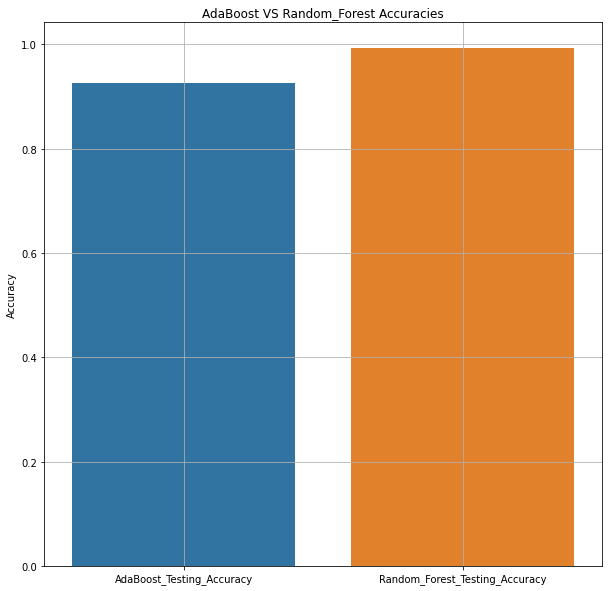

In [12]:
sorted_acc_tup = sorted(acc_dict.items(),key=lambda item:item[1])
acc_dict = {k:v for k,v in sorted_acc_tup}
plt.rcParams["figure.figsize"] = (10,10)

sns.barplot(x = list(acc_dict.keys()), y=list(acc_dict.values()))
plt.grid()
plt.ylabel('Accuracy')
plt.title('AdaBoost VS Random_Forest Accuracies');

# Implement Conditional GAN with Wasserstein loss

### Data scaling

In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
X_train_smoted_scaled = scaler.fit_transform(X_train_smoted)
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_smoted_scaled

array([[0.99249812, 0.24691239, 0.19038729, ..., 0.8       , 0.        ,
        0.24385902],
       [0.50187547, 0.8656828 , 0.48180773, ..., 0.07142857, 0.        ,
        0.85362741],
       [0.36184046, 0.76124423, 0.83948626, ..., 0.32857143, 0.        ,
        0.7560968 ],
       ...,
       [0.28982246, 0.53945756, 0.47422468, ..., 0.65714286, 0.        ,
        0.53656001],
       [0.75743936, 0.67476991, 0.16140315, ..., 0.67142857, 0.        ,
        0.68287282],
       [0.03325831, 0.68059008, 0.16064208, ..., 0.04285714, 0.        ,
        0.68287282]])

### Hyperparameters

In [14]:
batch_size = 1024
num_classes = 2
take_size = 12
latent_dim = 126

## Put the Dataset in tensors

In [15]:
from tensorflow import keras
from keras import layers
task_shape = (take_size + num_classes, 1)
X_train_smoted = X_train_smoted.astype(np.float32)
X_train_smoted_scaled = X_train_smoted_scaled.astype(np.float32)
all_labels = keras.utils.to_categorical(y_train_smoted, 2)

dataset = tf.data.Dataset.from_tensor_slices((X_train_smoted_scaled, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
dataset

2022-08-28 11:55:22.804730: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<BatchDataset shapes: ((None, 12), (None, 2)), types: (tf.float32, tf.float32)>

## Build the Discriminator

In [16]:
def conv_block(x,filters,activation,kernel_size=2,strides=1,padding="same",use_bias=True,use_bn=False,use_dropout=False,drop_value=0.5,):
    x = layers.Conv1D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x

def get_discriminator_model():
    img_input = layers.Input(shape=task_shape)
    x = conv_block(img_input,64,kernel_size=3,strides=2,use_bn=False,use_bias=True,activation=layers.LeakyReLU(0.2),use_dropout=False,drop_value=0.3,)
    x = conv_block(x,128,kernel_size=3,strides=2,use_bn=False,activation=layers.LeakyReLU(0.2),use_bias=True,use_dropout=True,drop_value=0.3,)
    x = conv_block(x,256,kernel_size=2,strides=2,use_bn=False,activation=layers.LeakyReLU(0.2),use_bias=True,use_dropout=True,drop_value=0.3,)
    x = conv_block(x,512,kernel_size=3,strides=2,use_bn=False,activation=layers.LeakyReLU(0.2),use_bias=True,use_dropout=False,drop_value=0.3,)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1,activation='sigmoid')(x)
    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model

d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7, 64)             256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 7, 64)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 128)            24704     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 256)          

## Build the Generator

In [17]:

def block(x,filters,activation,kernel_size=3,strides=1,padding="same",use_bn=False,use_bias=True,use_dropout=False,drop_value=0.3,):
    x = layers.Conv1D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x

def get_generator_model():
    noise = layers.Input(shape=(latent_dim+num_classes,))
    x = layers.Dense(4 * 4 * 256, use_bias=False,activation='relu')(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dense(256, use_bias=False,activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(take_size,activation='leaky_relu')(x)
    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              524288    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1048576   
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0 

## Build the CGAN Model

In [18]:
class CGAN(keras.Model):
    def __init__(self,discriminator,generator,latent_dim,):
        super(CGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(CGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_task,one_hot_labeld=data
        if isinstance(real_task, tuple):
            real_task = real_task[0]

        real_task=tf.concat([real_task,one_hot_labeld],axis=1)
        # Get the batch size
        batch_size = tf.shape(real_task)[0]

        # Get the latent vector
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim),seed=seed
        )
        random_latent_vectors=tf.concat([random_latent_vectors,one_hot_labeld],axis=1)

        # Generate fake images from the latent vector
        fake_task = self.generator(random_latent_vectors)
        # Get the logits for the fake images
        fake_task=tf.concat([fake_task,one_hot_labeld],axis=1)
        combined_tasks = tf.concat(
            [real_task,fake_task], axis=0
        )

         # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_tasks)
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim),seed=seed)
        random_latent_vectors=tf.concat([random_latent_vectors,one_hot_labeld],axis=1)

        # Assemble labels that say "all real images".
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_task = self.generator(random_latent_vectors, training=True)
            generated_task=tf.concat([generated_task,one_hot_labeld],axis=1)

            predictions = self.discriminator(generated_task)
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

# Train the CGAN on the training dataset

In [19]:
# Set the number of epochs for training.
epochs = 11

# Get the wgan model
cgan = CGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=latent_dim)

# Compile the wgan model
cgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    loss_fn=keras.losses.BinaryCrossentropy())

# Start training
cgan.fit(dataset, batch_size=batch_size, epochs=epochs)

Epoch 1/11


2022-08-28 11:55:25.005324: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


20/20 [==============================] - 15s 607ms/step - g_loss: 0.5320 - d_loss: 0.6618
Epoch 2/11
20/20 [==============================] - 12s 600ms/step - g_loss: 0.4645 - d_loss: 0.6522
Epoch 3/11
20/20 [==============================] - 12s 597ms/step - g_loss: 1.7767 - d_loss: 0.4977
Epoch 4/11
20/20 [==============================] - 12s 616ms/step - g_loss: 2.7604 - d_loss: 0.3974
Epoch 5/11
20/20 [==============================] - 12s 598ms/step - g_loss: 2.3978 - d_loss: 0.3131
Epoch 6/11
20/20 [==============================] - 12s 599ms/step - g_loss: 2.3388 - d_loss: 0.1918
Epoch 7/11
20/20 [==============================] - 12s 621ms/step - g_loss: 1.5900 - d_loss: 0.1930
Epoch 8/11
20/20 [==============================] - 12s 595ms/step - g_loss: 1.4176 - d_loss: 0.0993
Epoch 9/11
20/20 [==============================] - 12s 610ms/step - g_loss: 1.0567 - d_loss: 0.1103
Epoch 10/11
20/20 [==============================] - 12s 596ms/step - g_loss: 0.7869 - d_loss: 0.1813


# Generate synthetic fake tasks via Generator network in CGAN after the training procedure

**To hack the model we will generate unligitimate (milicious) tasks and label them as 0**

In [20]:
num_of_tasks=2000
trained_gen = cgan.generator
one_hot_example = keras.utils.to_categorical([0]*num_of_tasks, 2)
# Sample noise for the interpolation.
fake_noise = tf.random.normal(shape=(num_of_tasks, latent_dim),seed=seed)
# Combine the noise and the labels and run inference with the generator.
noise_and_labels = tf.concat([fake_noise, one_hot_example], 1)
fake = trained_gen.predict(noise_and_labels)

In [21]:
fake.shape

(2000, 12)

In [22]:
fake_inverse= scaler.inverse_transform(fake)
fake_tasks_df= pd.DataFrame(fake_inverse,columns=df.columns[:-1])
fake_tasks_df

,ID,Latitude,Longitude,Day,Hour,Minute,Duration,RemainingTime,Resources,Coverage,OnPeakHours,GridNumber
0,-208.853149,45.546463,-75.326515,2.437549,4.287717,21.352703,51.556355,43.081917,2.578950,67.493523,0.035098,359076.125000
1,-260.506927,45.548111,-75.221718,1.115067,-0.204731,21.601234,22.554279,51.355869,4.098998,63.009647,-0.007081,129746.382812
2,-936.389771,45.551994,-75.224144,0.928016,9.707979,115.782249,100.896072,43.008263,1.602001,61.852474,0.297071,362608.500000
3,-542.968811,45.603287,-75.282722,2.241450,4.083251,81.315071,84.776512,51.691746,3.459776,70.230148,0.245409,318508.187500
4,-57.871788,45.523571,-75.340210,-0.335941,-0.301348,-0.907958,21.460632,46.525784,1.671444,64.615334,0.191337,231395.640625
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-450.870514,45.503571,-75.268433,0.137040,3.679984,40.284489,54.672070,47.666691,4.030846,80.992973,0.298794,286496.125000
1996,52.318569,45.353325,-75.349701,-0.456256,-1.302507,-2.700469,22.975868,33.020267,5.345357,49.334339,0.276254,202468.031250
1997,-1243.024292,45.612442,-75.041985,6.062290,17.821672,174.741318,137.906219,45.149410,2.269790,78.004456,0.130284,449753.750000
1998,430.916626,45.384480,-75.337631,-0.145411,-1.427666,-2.841817,11.797066,31.016529,4.978550,41.590504,0.004260,274138.687500


In [23]:
fake_tasks_df.to_csv('Generated_fake_milicious_tasks.csv',index=False)

**To test the quality of our generation**

In [24]:
mm = adaBoostClassifier.predict(fake_tasks_df)
pd.DataFrame(mm).value_counts()

1    1857
0     143
dtype: int64

> - the model fail to detect 1862 sample of the fake data, and only detected 138 sample. It's a good evidence that we succeeded in scammimg the model because all this tasks should be calssified as unligitmate


# Mix the generated fake tasks with the original test dataset to obtain a new test dataset

In [25]:
mixed_test_dataset=pd.concat([X_test,fake_tasks_df])
mixed_test_dataset=mixed_test_dataset.reset_index()
mixed_test_dataset.drop('index',axis=1,inplace=True)
mixed_test_dataset

,ID,Latitude,Longitude,Day,Hour,Minute,Duration,RemainingTime,Resources,Coverage,OnPeakHours,GridNumber
0,1031.000000,45.556369,-75.201917,3.000000,11.000000,9.000000,40.000000,20.000000,1.000000,86.000000,0.000000,319073.00000
1,209.000000,45.469987,-75.155623,4.000000,16.000000,8.000000,60.000000,10.000000,8.000000,53.000000,0.000000,178319.00000
2,3653.000000,45.536579,-75.161880,5.000000,8.000000,35.000000,50.000000,30.000000,8.000000,63.000000,1.000000,290926.00000
3,94.000000,45.392164,-75.235236,4.000000,4.000000,36.000000,40.000000,30.000000,6.000000,74.000000,0.000000,37549.00000
4,1283.000000,45.496407,-75.183561,4.000000,4.000000,1.000000,50.000000,30.000000,5.000000,60.000000,0.000000,215851.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
4892,-450.870514,45.503571,-75.268433,0.137040,3.679984,40.284489,54.672070,47.666691,4.030846,80.992973,0.298794,286496.12500
4893,52.318569,45.353325,-75.349701,-0.456256,-1.302507,-2.700469,22.975868,33.020267,5.345357,49.334339,0.276254,202468.03125
4894,-1243.024292,45.612442,-75.041985,6.062290,17.821672,174.741318,137.906219,45.149410,2.269790,78.004456,0.130284,449753.75000
4895,430.916626,45.384480,-75.337631,-0.145411,-1.427666,-2.841817,11.797066,31.016529,4.978550,41.590504,0.004260,274138.68750


**Should label all these tasks as unligitimate tasks**

In [26]:
y_for_fake_tasks=pd.DataFrame({'Ligitimacy':[0]*2000},)
mixed_y_test=pd.concat([y_test,y_for_fake_tasks['Ligitimacy']])
mixed_y_test=mixed_y_test.reset_index()
mixed_y_test.drop('index',axis=1,inplace=True)
mixed_y_test

,Ligitimacy
0,1
1,0
2,0
3,1
4,1
...,...
4892,0
4893,0
4894,0
4895,0


# Obtain Adaboost and RF detection performance using the new test dataset and compare the results

AdaBoostClassifier accuracy for the mixed data= 0.576883806412089
RandomForestClassifier accuracy for the mixed data = 0.5952624055544211


<AxesSubplot:>

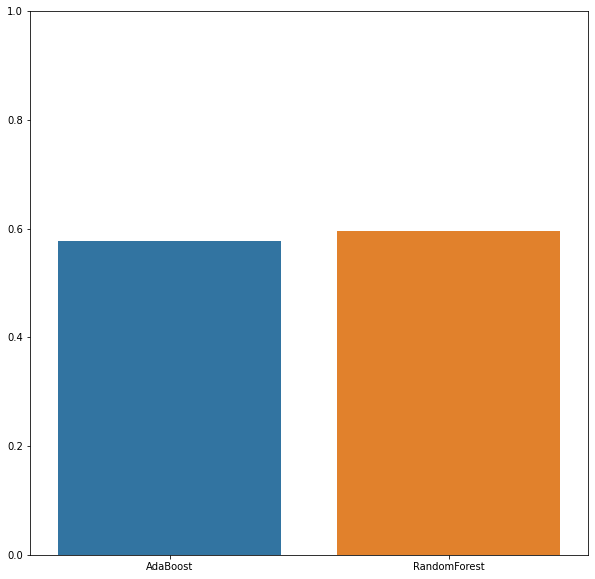

In [27]:
adaboost_accuracy=adaBoostClassifier.score(mixed_test_dataset,mixed_y_test)
rf_accuracy=randomForestClassifier.score(mixed_test_dataset,mixed_y_test)
print(f'AdaBoostClassifier accuracy for the mixed data= {adaboost_accuracy}')
print(f'RandomForestClassifier accuracy for the mixed data = {rf_accuracy}')
plt.figure(figsize=(10,10))
plt.ylim(0,1)
sns.barplot(x=['AdaBoost','RandomForest'],y=[adaboost_accuracy,rf_accuracy])

**Our generated data scammed the models very well as:**
> - The Adaboost's accuracy has been decreased from 0.925 to 0.575 .
> - the Random forest's accuracy has been decreased from 0.990 to 0.590.

# Consider the Discriminator to as the first level classifier and RF/Adaboost as the second level classifier

**Because of our discriminator is trained on scaled data, so we will scale this data**

In [28]:
mixed_test_dataset_scaled=scaler.transform(mixed_test_dataset)
mixed_test_dataset_scaled

array([[ 0.25756439,  0.87078121,  0.53914657, ...,  0.8       ,
         0.        ,  0.85363261],
       [ 0.052013  ,  0.4764824 ,  0.72794642, ...,  0.32857143,
         0.        ,  0.4878012 ],
       [ 0.91322831,  0.78044984,  0.70242734, ...,  0.47142857,
         1.        ,  0.7804762 ],
       ...,
       [-0.31108384,  1.12673044,  1.19139557, ...,  0.68577794,
         0.13028365,  1.1932828 ],
       [ 0.10750603,  0.08617771, -0.01433721, ...,  0.16557862,
         0.0042596 ,  0.73684458],
       [-0.33195408,  1.00505199,  1.0325541 , ...,  0.73309326,
         0.17394227,  1.16484817]])

**Concat the labels as one hot encoding**

In [29]:
one_hot_examples_for_mixed_dataset = keras.utils.to_categorical(mixed_y_test, 2)
mixed_test_dataset_scaled_and_labels = tf.concat([mixed_test_dataset_scaled, one_hot_examples_for_mixed_dataset], 1)
mixed_test_dataset_scaled_and_labels.shape

TensorShape([4897, 14])

### Detect the real and fake tasks using the discriminator as first level classification

In [30]:
trained_disc=cgan.discriminator

In [31]:
y_pred_mixed_from_disc=trained_disc.predict(mixed_test_dataset_scaled_and_labels)
y_pred_mixed_from_disc=np.apply_along_axis(lambda x:1 if x >=0.5 else 0,axis=1,arr=y_pred_mixed_from_disc,)
y_pred_mixed_from_disc=pd.DataFrame(y_pred_mixed_from_disc)
# y_pred_mixed_from_disc

## Filter synthetic tasks

In [32]:
index_of_real= y_pred_mixed_from_disc[y_pred_mixed_from_disc[0]==1].index.tolist()
filtered_real_tasks= mixed_test_dataset.loc[index_of_real,:]
filtered_real_tasks

,ID,Latitude,Longitude,Day,Hour,Minute,Duration,RemainingTime,Resources,Coverage,OnPeakHours,GridNumber
0,1031.0,45.556369,-75.201917,3.0,11.0,9.0,40.0,20.0,1.0,86.0,0.0,319073.0
1,209.0,45.469987,-75.155623,4.0,16.0,8.0,60.0,10.0,8.0,53.0,0.0,178319.0
2,3653.0,45.536579,-75.161880,5.0,8.0,35.0,50.0,30.0,8.0,63.0,1.0,290926.0
3,94.0,45.392164,-75.235236,4.0,4.0,36.0,40.0,30.0,6.0,74.0,0.0,37549.0
4,1283.0,45.496407,-75.183561,4.0,4.0,1.0,50.0,30.0,5.0,60.0,0.0,215851.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2892,3139.0,45.541575,-75.126146,5.0,3.0,49.0,40.0,30.0,10.0,42.0,0.0,300314.0
2893,3388.0,45.479362,-75.218738,1.0,7.0,22.0,40.0,10.0,3.0,61.0,1.0,187695.0
2894,3426.0,45.504521,-75.275448,5.0,23.0,56.0,40.0,10.0,4.0,38.0,0.0,234608.0
2895,3085.0,45.551647,-75.291245,0.0,22.0,47.0,40.0,30.0,2.0,33.0,0.0,319062.0


In [33]:
y_actual_of_filtered_tasks=mixed_y_test.loc[index_of_real,:]
# y_actual_of_filtered_tasks

### Using the classic classifiers as a second level after filtering the fake tasks

AdaBoostClassifier accuracy for the mixed data = 0.925520649488175
RandomForestClassifier accuracy for the mixed data = 0.9925873632192023


<AxesSubplot:>

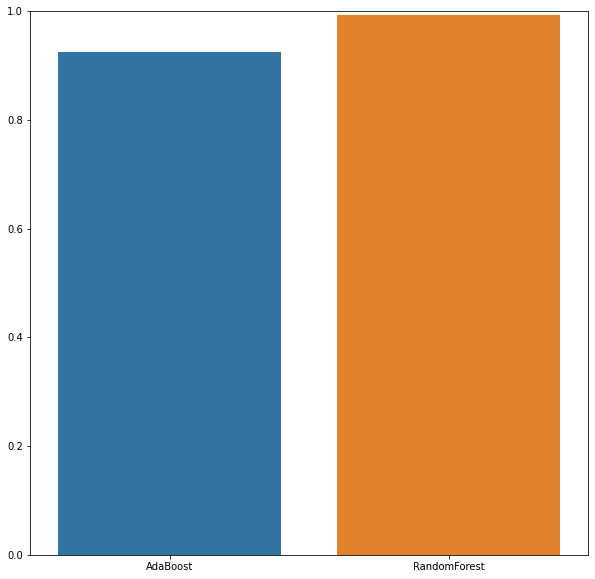

In [34]:
y_pred_ada_for_filtered_mixed_test=adaBoostClassifier.predict(filtered_real_tasks)
y_pred_rf_for_filtered_mixed_test=randomForestClassifier.predict(filtered_real_tasks)
adaboost_accuracy=accuracy_score(y_actual_of_filtered_tasks,y_pred_ada_for_filtered_mixed_test)
rf_accuracy=accuracy_score(y_actual_of_filtered_tasks,y_pred_rf_for_filtered_mixed_test)
print(f'AdaBoostClassifier accuracy for the mixed data = {adaboost_accuracy}')
print(f'RandomForestClassifier accuracy for the mixed data = {rf_accuracy}')
plt.figure(figsize=(10,10))
plt.ylim(0,1)
sns.barplot(x=['AdaBoost','RandomForest'],y=[adaboost_accuracy,rf_accuracy],)

This is approximately the original accuracies before adding the fake tasks, and it's a good results because our discriminator is able to filter the fake tasks and our classic classifiers are now able to classify the real tasks if they ligitimit or not as they used to do

# Conclusion
The generated tasks from the generator are robust and succussed to fault the classic ML algorithms because it is tried to generate tasks very close to the real one, so the models can’t determine it and the accuracies has been decreased from 0.92 to 0.575 in the Adaboost model and has been decreased from 0.993 to 0.590 in the Random Forest model.
In the cascade approach the discriminator helped the models because it can filter the fake tasks, so after the filtering it out the accuracies increased again to 0.926 in Adaboost and to 0.993 in the Random Forest model and this result is approximately one before mixing which means that the discriminator filtered.

**Resources**
1. GAN implementation via keras https://keras.io/examples/generative/conditional_gan/
2. GAN implementation via tensorflow https://www.tensorflow.org/tutorials/generative/dcgan
3. GAN tutorial https://towardsdatascience.com/generative-adversarial-network-gan-for-dummies-a-step-bystep-tutorial-fdefff170391